# Compressor Bottleneck Analysis with NeqSim

This notebook demonstrates process simulation and optimization with NeqSim, including:
- Building a multi-train gas processing system (4 inlet trains → 3 compressor trains)
- Configuring compressors with performance charts and VFD motor drivers
- Analyzing equipment capacity utilization and detecting bottlenecks
- Two-stage production optimization (load balancing + throughput maximization)
- Visualizing compressor operating points on performance curves

## 1. Import Required Libraries and Setup NeqSim

Import NeqSim classes using direct Java access via jpype. This includes ProcessSystem, Stream, Splitter, Compressor, Separator, PipeBeggsAndBrills, Manifold, CompressorDriver, and StreamSaturatorUtil.

In [1]:
import neqsim
from neqsim import jneqsim

# Import Java classes for direct access
SystemPrEos = jneqsim.thermo.system.SystemPrEos
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
Splitter = jneqsim.process.equipment.splitter.Splitter
Compressor = jneqsim.process.equipment.compressor.Compressor
CompressorDriver = jneqsim.process.equipment.compressor.CompressorDriver
DriverType = jneqsim.process.equipment.compressor.DriverType
Separator = jneqsim.process.equipment.separator.Separator
ThreePhaseSeparator = jneqsim.process.equipment.separator.ThreePhaseSeparator
PipeBeggsAndBrills = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills
Manifold = jneqsim.process.equipment.manifold.Manifold
StreamSaturatorUtil = jneqsim.process.equipment.util.StreamSaturatorUtil
Mixer = jneqsim.process.equipment.mixer.Mixer
Pump = jneqsim.process.equipment.pump.Pump
Cooler = jneqsim.process.equipment.heatexchanger.Cooler

## 2. Create Test Fluid System

Create a SystemPrEos fluid with natural gas composition using the Peng-Robinson equation of state.

In [81]:
# Create test fluid with natural gas composition
test_system = SystemPrEos(298.15, 10.0)  # Temperature in K, Pressure in bara
test_system = SystemPrEos(298.15, 10.0)
for comp, frac in [("nitrogen", 0.0165), ("methane", 0.9271), ("ethane", 0.0305), ("propane", 0.0053),
                    ("i-butane", 0.0035), ("n-butane", 0.0008), ("i-pentane", 0.0007), ("n-pentane", 0.0002),
                    ("n-hexane", 0.0001), ("benzene", 0.0011), ("n-heptane", 0.0002), ("water", 0.0038)]:
    test_system.addComponent(comp, frac)
test_system.setMixingRule("classic")
test_system.setMultiPhaseCheck(True)

## 3. Build Inlet Stream and Water Saturator

Create the inlet stream with specified flow rate, temperature, and pressure. Add a water saturator to saturate the gas stream with water vapor.

In [82]:
# Create process system
process_system = ProcessSystem()

# Create inlet stream
inlet_stream = Stream("Inlet Stream", test_system)
inlet_stream.setFlowRate(2097870.58288790, "kg/hr")
inlet_stream.setTemperature(48.5, "C")
inlet_stream.setPressure(37.16, "bara")
inlet_stream.run()
process_system.add(inlet_stream)

# Saturate the stream with water
saturator = StreamSaturatorUtil("Water Saturator", inlet_stream)
saturator.run()
process_system.add(saturator)

# Get the water-saturated outlet stream
saturated_stream = Stream("Saturated Stream", saturator.getOutletStream())
saturated_stream.run()
process_system.add(saturated_stream)

print(f"Inlet Stream:")
print(f"  Flow rate: {inlet_stream.getFlowRate('kg/hr'):.0f} kg/hr")
print(f"  Temperature: {inlet_stream.getTemperature('C'):.1f} °C")
print(f"  Pressure: {inlet_stream.getPressure('bara'):.2f} bara")

Inlet Stream:
  Flow rate: 2097871 kg/hr
  Temperature: 48.5 °C
  Pressure: 37.16 bara


## 4. Create Splitter and Processing Trains

Create a 4-way splitter and processing trains. Each train consists of an inlet pipe, three-phase separator, and outlet pipe.

In [83]:
def create_processing_train(train_name, inlet_stream, process_system):
    """Creates a processing train with pipe, separator, and outlet pipe."""
    
    # Inlet pipe
    inlet_pipe = PipeBeggsAndBrills(train_name + " Inlet Pipe", inlet_stream)
    inlet_pipe.setLength(800.0)  # meters
    inlet_pipe.setDiameter(0.69)  # meters
    inlet_pipe.setPipeWallRoughness(15e-6)
    inlet_pipe.setElevation(0)
    inlet_pipe.run()
    process_system.add(inlet_pipe)
    
    # Three-phase separator
    separator = ThreePhaseSeparator(train_name + " Separator", inlet_pipe.getOutletStream())
    separator.run()
    process_system.add(separator)
    
    # Outlet pipe
    outlet_pipe = PipeBeggsAndBrills(train_name + " Outlet Pipe", separator.getGasOutStream())
    outlet_pipe.setLength(100.0)  # meters
    outlet_pipe.setDiameter(0.60)  # meters
    outlet_pipe.setPipeWallRoughness(15e-6)
    outlet_pipe.setElevation(0)
    outlet_pipe.setNumberOfIncrements(10)
    outlet_pipe.run()
    process_system.add(outlet_pipe)
    
    return outlet_pipe

# Create first splitter
splitter = Splitter("Test Splitter", saturated_stream)
splitter.setSplitFactors([0.25, 0.25, 0.25, 0.25])
splitter.run()
process_system.add(splitter)

# Create processing trains for each split stream
train1_outlet = create_processing_train("Train1", splitter.getSplitStream(0), process_system)
train2_outlet = create_processing_train("Train2", splitter.getSplitStream(1), process_system)
train3_outlet = create_processing_train("Train3", splitter.getSplitStream(2), process_system)
train4_outlet = create_processing_train("Train4", splitter.getSplitStream(3), process_system)

print("Created 4 processing trains with pipes and separators")

Created 4 processing trains with pipes and separators


## 5. Build Final Separator and Second Splitter

Combine all four processing train outlets in a final separator, then split to three compressor trains.

In [84]:
# Create final separator combining all train outlets
final_separator = ThreePhaseSeparator("Final Separator")
final_separator.addStream(train1_outlet.getOutletStream())
final_separator.addStream(train2_outlet.getOutletStream())
final_separator.addStream(train3_outlet.getOutletStream())
final_separator.addStream(train4_outlet.getOutletStream())
final_separator.setInternalDiameter(3.0)
final_separator.run()
process_system.add(final_separator)

# Create second splitter for compressor trains (slightly unequal distribution)
splitter2 = Splitter("Test Splitter2", final_separator.getGasOutStream())
splitter2.setSplitFactors([0.95 / 3.0, 1.0 / 3.0, 1.05 / 3.0])
splitter2.run()
process_system.add(splitter2)

print(f"Final separator internal diameter: {final_separator.getInternalDiameter()} m")
print(f"Splitter 2 split factors: {[0.95/3.0, 1.0/3.0, 1.05/3.0]}")

Final separator internal diameter: 3.0 m
Splitter 2 split factors: [0.31666666666666665, 0.3333333333333333, 0.35000000000000003]


## 6. Create Upstream Compressor Trains

Create three compressor trains, each with inlet pipe, separator, outlet pipe, and compressor.

In [85]:
def create_upstream_compressors(train_name, inlet_stream, process_system):
    """Creates an upstream compressor train with pipes, separator, compressor, and cooler."""
    
    # Print inlet conditions
    print(f"\n=== {train_name} INLET CONDITIONS ===")
    print(f"Inlet Pressure: {inlet_stream.getPressure('bara'):.2f} bara")
    print(f"Inlet Flow: {inlet_stream.getFlowRate('kg/hr'):.0f} kg/hr")
    print(f"Gas Density: {inlet_stream.getFluid().getDensity('kg/m3'):.2f} kg/m3")
    
    # Inlet pipe
    inlet_pipe = PipeBeggsAndBrills(train_name + " ups Pipe", inlet_stream)
    inlet_pipe.setLength(50)  # meters
    inlet_pipe.setDiameter(0.706)  # meters
    inlet_pipe.setPipeWallRoughness(15e-6)
    inlet_pipe.setElevation(0)
    inlet_pipe.run()
    process_system.add(inlet_pipe)
    
    # Separator
    separator = Separator(train_name + " ups Separator", inlet_pipe.getOutletStream())
    separator.run()
    process_system.add(separator)
    
    # Outlet pipe
    outlet_pipe = PipeBeggsAndBrills(train_name + " ups Outlet Pipe", separator.getGasOutStream())
    outlet_pipe.setLength(50.0)  # meters
    outlet_pipe.setDiameter(0.706)  # meters
    outlet_pipe.setPipeWallRoughness(15e-6)
    outlet_pipe.setElevation(0)
    outlet_pipe.run()
    process_system.add(outlet_pipe)
    
    # Compressor
    compressor = Compressor(train_name + " Compressor", outlet_pipe.getOutletStream())
    compressor.setOutletPressure(110.0, "bara")
    compressor.setUsePolytropicCalc(True)
    compressor.setPolytropicEfficiency(0.85)
    compressor.setSpeed(8000)
    compressor.run()
    process_system.add(compressor)
    
    # Cooler after compressor (47°C outlet, 0.15 bar pressure drop)
    cooler = Cooler(train_name + " Cooler", compressor.getOutletStream())
    cooler.setOutTemperature(47.0, "C")
    cooler.setPressureDrop(0.15)  # bar
    cooler.run()
    process_system.add(cooler)

    # Outlet pipe (after cooler)
    outlet_pipe2 = PipeBeggsAndBrills(train_name + " ups Outlet Pipe2", cooler.getOutletStream())
    outlet_pipe2.setLength(100.0)  # meters
    outlet_pipe2.setDiameter(0.56)  # meters
    outlet_pipe2.setPipeWallRoughness(15e-6)
    outlet_pipe2.setElevation(0)
    outlet_pipe2.run()
    process_system.add(outlet_pipe2)
    
    return outlet_pipe2.getOutletStream()

# Create upstream compressor trains
ups1_outlet = create_upstream_compressors("ups1", splitter2.getSplitStream(0), process_system)
ups2_outlet = create_upstream_compressors("ups2", splitter2.getSplitStream(1), process_system)
ups3_outlet = create_upstream_compressors("ups3", splitter2.getSplitStream(2), process_system)


=== ups1 INLET CONDITIONS ===
Inlet Pressure: 36.75 bara
Inlet Flow: 663668 kg/hr
Gas Density: 25.01 kg/m3

=== ups2 INLET CONDITIONS ===
Inlet Pressure: 36.75 bara
Inlet Flow: 698597 kg/hr
Gas Density: 25.01 kg/m3

=== ups3 INLET CONDITIONS ===
Inlet Pressure: 36.75 bara
Inlet Flow: 733527 kg/hr
Gas Density: 25.01 kg/m3


## 7. Create Manifold and Run Process System

Create a manifold to combine all three compressor outlets and run the complete process system.

In [86]:
# Create manifold combining compressor outlets
manifold = Manifold("Compressor Outlet Manifold")
manifold.addStream(ups1_outlet)
manifold.addStream(ups2_outlet)
manifold.addStream(ups3_outlet)
manifold.setSplitFactors([1.0 / 3.0, 1.0 / 3.0, 1.0 / 3.0])
manifold.setHeaderInnerDiameter(1.5)
manifold.setBranchInnerDiameter(0.6)
manifold.run()
process_system.add(manifold)


# Liquid handling: collect from separators, pump, split to 3
liq_mixer = Mixer("Liquid Mixer")
# Get separators from the 4 inlet processing trains
for train_name in ["Train1", "Train2", "Train3", "Train4"]:
    sep = process_system.getUnit(train_name + " Separator")
    liq_mixer.addStream(sep.getLiquidOutStream())
liq_mixer.addStream(final_separator.getOilOutStream())
liq_mixer.addStream(final_separator.getWaterOutStream())
liq_mixer.run()
process_system.add(liq_mixer)

pump = Pump("Liquid Export Pump", liq_mixer.getOutletStream())
pump.setOutletPressure(130.0, "bara"); pump.run()
process_system.add(pump)

liq_manifold = Manifold("Liquid Export Manifold")
liq_manifold.addStream(pump.getOutletStream())
liq_manifold.setSplitFactors([1/3, 1/3, 1/3])
liq_manifold.setHeaderInnerDiameter(0.3); liq_manifold.setBranchInnerDiameter(0.15)
liq_manifold.run()
process_system.add(liq_manifold)

# Export pipelines (3 x 50km) - mix gas + liquid, then pipeline
for i in range(3):
    mixer = Mixer(f"Export Mixer {i+1}")
    mixer.addStream(manifold.getSplitStream(i))
    mixer.addStream(liq_manifold.getSplitStream(i))
    mixer.run()
    process_system.add(mixer)
    pipe = PipeBeggsAndBrills(f"Export Pipeline {i+1}", mixer.getOutletStream())
    pipe.setLength(50000); pipe.setElevation(0.0); pipe.setDiameter(0.6); pipe.setPipeWallRoughness(15e-6)
    pipe.setNumberOfIncrements(50); pipe.run()
    process_system.add(pipe)
    

# Run the process system
process_system.run()

print("\nProcess system created and run successfully!")
print(f"Total unit operations: {process_system.getUnitOperations().size()}")


Process system created and run successfully!
Total unit operations: 46


## 8. Auto-size Equipment

Auto-size separators, compressors, and manifolds based on current operating conditions.

In [87]:
# Auto-size separators and compressors
for equipment in process_system.getUnitOperations():
    if isinstance(equipment, Separator):
        equipment.autoSize()
    elif isinstance(equipment, Compressor):
        equipment.autoSize()
    elif isinstance(equipment, Manifold):
        equipment.autoSize()

# Initialize pipe mechanical design with 30 m/s max velocity
for equipment in process_system.getUnitOperations():
    class_name = equipment.getClass().getSimpleName()
    if class_name == "PipeBeggsAndBrills":
        equipment.initMechanicalDesign()
        equipment.setMaxDesignVelocity(30.0)  # 30 m/s max (auto-clears cached constraints)

print("Equipment auto-sizing and pipe mechanical design initialization complete")

Equipment auto-sizing and pipe mechanical design initialization complete


## 9. Configure Compressor Charts and Drivers

Load compressor performance charts from JSON files and configure VFD motor drivers with tabular speed-dependent power curves using `setMaxPowerSpeedCurve(speeds, powers, unit)`.

In [88]:
# Configure ups1 compressor with driver curve
ups1_comp = process_system.getUnit("ups1 Compressor")
ups1_comp.getMechanicalDesign().setMaxDesignPower(50000.0)
ups1_comp.loadCompressorChartFromJson("C:/temp/compressor_curve_ups2.json")
ups1_comp.setSolveSpeed(True)

# ups1 and ups2: Same compressor curve, 44.4 MW max at 7383 RPM
driver1 = CompressorDriver(DriverType.VFD_MOTOR, 44400.0)
driver1.setRatedSpeed(7383.0)
speeds_ups1 = [4922.0, 5200.0, 5500.0, 5800.0, 6100.0, 6400.0, 6700.0, 6900.0, 7100.0, 7200.0, 7300.0, 7383.0]
powers_ups1 = [28.0, 30.5, 33.5, 36.5, 39.5, 42.0, 43.8, 44.2, 44.35, 44.38, 44.40, 44.40]
driver1.setMaxPowerSpeedCurve(speeds_ups1, powers_ups1, "MW")
ups1_comp.setDriver(driver1)

# Configure ups2 compressor (same driver specs as ups1)
ups2_comp = process_system.getUnit("ups2 Compressor")
ups2_comp.getMechanicalDesign().setMaxDesignPower(50000.0)
ups2_comp.loadCompressorChartFromJson("C:/temp/compressor_curve_ups2.json")
ups2_comp.setSolveSpeed(True)
driver2 = CompressorDriver(DriverType.VFD_MOTOR, 44400.0)
driver2.setRatedSpeed(7383.0)
driver2.setMaxPowerSpeedCurve(speeds_ups1, powers_ups1, "MW")
ups2_comp.setDriver(driver2)

# Configure ups3 compressor (different driver specs - 50 MW max at 6726 RPM)
ups3_comp = process_system.getUnit("ups3 Compressor")
ups3_comp.getMechanicalDesign().setMaxDesignPower(55000.0)
ups3_comp.loadCompressorChartFromJson("C:/temp/compressor_curve_ups3.json")
ups3_comp.setSolveSpeed(True)
driver3 = CompressorDriver(DriverType.VFD_MOTOR, 50000.0)
driver3.setRatedSpeed(6726.3)
speeds_ups3 = [4484.0, 4700.0, 4950.0, 5200.0, 5450.0, 5700.0, 5950.0, 6150.0, 6350.0, 6500.0, 6600.0, 6680.0, 6726.0]
powers_ups3 = [30.0, 33.0, 36.5, 40.0, 43.5, 46.5, 48.5, 49.2, 49.6, 49.85, 49.93, 49.98, 50.0]
driver3.setMaxPowerSpeedCurve(speeds_ups3, powers_ups3, "MW")
ups3_comp.setDriver(driver3)

process_system.run()

print("Compressor charts and drivers configured:")
print(f"  ups1: {driver1.getRatedPower():.0f} kW @ {driver1.getRatedSpeed():.0f} RPM")
print(f"  ups2: {driver2.getRatedPower():.0f} kW @ {driver2.getRatedSpeed():.0f} RPM")  
print(f"  ups3: {driver3.getRatedPower():.0f} kW @ {driver3.getRatedSpeed():.0f} RPM")

Compressor charts and drivers configured:
  ups1: 44400 kW @ 7383 RPM
  ups2: 44400 kW @ 7383 RPM
  ups3: 50000 kW @ 6726 RPM


## 10. Verify Compressor Inlet Flows

In [89]:
# Verify compressor inlet flow
ups1_flow = process_system.getUnit("ups1 Compressor").getInletStream().getFlowRate("kg/hr")
ups2_flow = process_system.getUnit("ups2 Compressor").getInletStream().getFlowRate("kg/hr")
ups3_flow = process_system.getUnit("ups3 Compressor").getInletStream().getFlowRate("kg/hr")

print("=== COMPRESSOR INLET FLOWS ===")
print(f"UPS-1 inlet: {ups1_flow:,.0f} kg/hr")
print(f"UPS-2 inlet: {ups2_flow:,.0f} kg/hr")
print(f"UPS-3 inlet: {ups3_flow:,.0f} kg/hr")
print(f"Total:       {ups1_flow + ups2_flow + ups3_flow:,.0f} kg/hr")

=== COMPRESSOR INLET FLOWS ===
UPS-1 inlet: 663,668 kg/hr
UPS-2 inlet: 698,597 kg/hr
UPS-3 inlet: 733,527 kg/hr
Total:       2,095,792 kg/hr


## 11. Analyze Pipe Velocities

In [90]:
print("=== PIPE VELOCITY ANALYSIS ===")
max_allowed_velocity = 30.0  # m/s - max for gas pipes

print(f"{'Pipe Name':<30}  {'Velocity':>10}  {'Diameter':>10}  {'Status':>8}")
print(f"{'':<30}  {'(m/s)':>10}  {'(m)':>10}  {''}")
print("-" * 65)

for equipment in process_system.getUnitOperations():
    class_name = equipment.getClass().getSimpleName()
    if class_name == "PipeBeggsAndBrills":
        pipe = equipment
        v_max = max(float(pipe.getInletSuperficialVelocity()), float(pipe.getOutletSuperficialVelocity()))
        diameter = float(pipe.getDiameter())
        status = "HIGH!" if v_max > max_allowed_velocity else "OK"
        print(f"{str(pipe.getName()):<30}  {v_max:>10.1f}  {diameter:>10.2f}  {status:>8}")

=== PIPE VELOCITY ANALYSIS ===
Pipe Name                         Velocity    Diameter    Status
                                     (m/s)         (m)  
-----------------------------------------------------------------
Train1 Inlet Pipe                     15.5        0.69        OK
Train1 Outlet Pipe                    20.6        0.60        OK
Train2 Inlet Pipe                     15.5        0.69        OK
Train2 Outlet Pipe                    20.6        0.60        OK
Train3 Inlet Pipe                     15.5        0.69        OK
Train3 Outlet Pipe                    20.6        0.60        OK
Train4 Inlet Pipe                     15.5        0.69        OK
Train4 Outlet Pipe                    20.6        0.60        OK
ups1 ups Pipe                         18.8        0.71        OK
ups1 ups Outlet Pipe                  18.9        0.71        OK
ups1 ups Outlet Pipe2                  9.2        0.56        OK
ups2 ups Pipe                         19.8        0.71        OK
u

## 12. Equipment Capacity Utilization

In [91]:
print("=== EQUIPMENT CAPACITY UTILIZATION ===")
utilization_summary = process_system.getCapacityUtilizationSummary()

for entry in utilization_summary.entrySet():
    print(entry.getKey(), entry.getValue())

=== EQUIPMENT CAPACITY UTILIZATION ===
Train1 Inlet Pipe 51.75865694323102
Train1 Separator 83.96407463849572
Train1 Outlet Pipe 68.6166029994295
Train2 Inlet Pipe 51.75865694323102
Train2 Separator 83.96407463849572
Train2 Outlet Pipe 68.6166029994295
Train3 Inlet Pipe 51.75865694323102
Train3 Separator 83.96407463849572
Train3 Outlet Pipe 68.6166029994295
Train4 Inlet Pipe 51.75865694323102
Train4 Separator 83.96407463849572
Train4 Outlet Pipe 68.6166029994295
Final Separator 83.96253924762567
ups1 ups Pipe 62.827552518096596
ups1 ups Separator 83.9620059586713
ups1 ups Outlet Pipe 62.880533469383224
ups1 Compressor 90.65484048222086
ups1 Cooler 0.0
ups1 ups Outlet Pipe2 30.61905914468877
ups2 ups Pipe 66.14021480046311
ups2 ups Separator 83.96194898605638
ups2 ups Outlet Pipe 66.20196399009619
ups2 Compressor 95.74489742757932
ups2 Cooler 0.0
ups2 ups Outlet Pipe2 32.23344254518278
ups3 ups Pipe 69.45379003858056
ups3 ups Separator 83.96188912363476
ups3 ups Outlet Pipe 69.525228690

## 13. Compressor Power and Margins Analysis

In [92]:
comp = process_system.getUnit("ups1 Compressor")

if comp is not None:
    power_kw = comp.getPower("kW")
    max_power = comp.getMechanicalDesign().maxDesignPower
    
    print("=== COMPRESSOR POWER ===")
    print(f"Compressor: {comp.getName()}")
    print(f"Power: {power_kw:.2f} kW ({power_kw/1000:.2f} MW)")
    if max_power > 0:
        print(f"Max Design Power: {max_power:.2f} kW ({max_power/1000:.2f} MW)")
        print(f"Power Utilization: {(power_kw / max_power) * 100:.2f}%")
    
    print("\n=== COMPRESSOR MARGINS ===")
    print(f"Speed: {comp.getSpeed():.0f} RPM")
    print(f"Max Speed: {comp.getMaximumSpeed():.0f} RPM")
    print(f"Min Speed: {comp.getMinimumSpeed():.0f} RPM")
    print(f"Chart Max Speed: {comp.getCompressorChart().getMaxSpeedCurve():.0f} RPM")
    print(f"Chart Min Speed: {comp.getCompressorChart().getMinSpeedCurve():.0f} RPM")
    print(f"Polytropic Head: {comp.getPolytropicFluidHead():.0f} J/kg")
    print(f"Polytropic Efficiency: {comp.getPolytropicEfficiency() * 100:.1f}%")
    print(f"Distance to Surge: {comp.getDistanceToSurge() * 100:.2f}%")
    print(f"Distance to Stonewall: {comp.getDistanceToStoneWall() * 100:.2f}%")
    print(f"Inlet Volume Flow: {comp.getInletStream().getFlowRate('m3/hr'):.0f} m3/hr")
    print(f"Inlet Pressure: {comp.getInletStream().getPressure('bara'):.2f} bara")
    print(f"Outlet Pressure: {comp.getOutletStream().getPressure('bara'):.2f} bara")

=== COMPRESSOR POWER ===
Compressor: ups1 Compressor
Power: 40220.35 kW (40.22 MW)
Max Design Power: 50000.00 kW (50.00 MW)
Power Utilization: 80.44%

=== COMPRESSOR MARGINS ===
Speed: 7155 RPM
Max Speed: 7383 RPM
Min Speed: 4922 RPM
Chart Max Speed: 7383 RPM
Chart Min Speed: 4922 RPM
Polytropic Head: 183 J/kg
Polytropic Efficiency: 83.9%
Distance to Surge: 47.42%
Distance to Stonewall: 61.87%
Inlet Volume Flow: 26585 m3/hr
Inlet Pressure: 36.69 bara
Outlet Pressure: 110.00 bara


## 14. Driver Curve Information

In [93]:
print("=== DRIVER CURVE (Speed-Dependent Max Power) ===")

for equipment in process_system.getUnitOperations():
    if isinstance(equipment, Compressor):
        compressor = equipment
        driver = compressor.getDriver()
        if driver is not None:
            print(f"\nCompressor: {compressor.getName()}")
            print(f"  Driver Type: {driver.getDriverType()}")
            print(f"  Rated Power: {driver.getRatedPower():.0f} kW")
            print(f"  Rated Speed: {driver.getRatedSpeed():.0f} RPM")
            print(f"  Current Speed: {compressor.getSpeed():.0f} RPM")
            max_power_at_speed = driver.getMaxAvailablePowerAtSpeed(compressor.getSpeed())
            print(f"  Max Power at Current Speed: {max_power_at_speed:.0f} kW")
            print(f"  Actual Power: {compressor.getPower('kW'):.0f} kW")
            power_utilization = compressor.getPower("kW") / max_power_at_speed * 100.0
            print(f"  Power Utilization (vs speed-dependent max): {power_utilization:.1f}%")

=== DRIVER CURVE (Speed-Dependent Max Power) ===

Compressor: ups1 Compressor
  Driver Type: VFD_MOTOR
  Rated Power: 44400 kW
  Rated Speed: 7383 RPM
  Current Speed: 7155 RPM
  Max Power at Current Speed: 44366 kW
  Actual Power: 40220 kW
  Power Utilization (vs speed-dependent max): 90.7%

Compressor: ups2 Compressor
  Driver Type: VFD_MOTOR
  Rated Power: 44400 kW
  Rated Speed: 7383 RPM
  Current Speed: 7212 RPM
  Max Power at Current Speed: 44382 kW
  Actual Power: 42494 kW
  Power Utilization (vs speed-dependent max): 95.7%

Compressor: ups3 Compressor
  Driver Type: VFD_MOTOR
  Rated Power: 50000 kW
  Rated Speed: 6726 RPM
  Current Speed: 6234 RPM
  Max Power at Current Speed: 49369 kW
  Actual Power: 43615 kW
  Power Utilization (vs speed-dependent max): 88.3%


## 15. Compressor Capacity Constraints

In [94]:
# Display capacity constraints for all compressors
print("=== COMPRESSOR CAPACITY CONSTRAINTS ===")
for equipment in process_system.getUnitOperations():
    if isinstance(equipment, Compressor):
        comp = equipment
        print(f"\n{comp.getName()}:")
        constraints = comp.getCapacityConstraints()
        for entry in constraints.entrySet():
            c = entry.getValue()
            constraint_type = "MIN" if c.isMinimumConstraint() else "MAX"
            print(f"  {str(entry.getKey()):18s}: {c.getUtilizationPercent():5.1f}% util, "
                  f"current={c.getCurrentValue():.2f}, limit={c.getDisplayDesignValue():.2f} ({constraint_type})")

=== COMPRESSOR CAPACITY CONSTRAINTS ===

ups1 Compressor:
  speed             :  89.4% util, current=7154.88, limit=8000.00 (MAX)
  minSpeed          :  74.5% util, current=7154.88, limit=5333.33 (MIN)
  power             :  90.7% util, current=90.65, limit=100.00 (MAX)
  ratedPower        :  90.6% util, current=90.59, limit=100.00 (MAX)
  surgeMargin       :  67.8% util, current=67.83, limit=100.00 (MAX)
  stonewallMargin   :  61.8% util, current=61.78, limit=100.00 (MAX)

ups2 Compressor:
  speed             :  90.2% util, current=7212.44, limit=8000.00 (MAX)
  minSpeed          :  73.9% util, current=7212.44, limit=5333.33 (MIN)
  power             :  95.7% util, current=95.74, limit=100.00 (MAX)
  ratedPower        :  95.7% util, current=95.71, limit=100.00 (MAX)
  surgeMargin       :  64.5% util, current=64.48, limit=100.00 (MAX)
  stonewallMargin   :  65.0% util, current=65.01, limit=100.00 (MAX)

ups3 Compressor:
  speed             :  77.9% util, current=6234.31, limit=8000.00 

In [95]:
# Initialize and display pipe capacity constraints
print("=== PIPE CAPACITY ANALYSIS ===")

for equipment in process_system.getUnitOperations():
    class_name = equipment.getClass().getSimpleName()
    if class_name == "PipeBeggsAndBrills":
        pipe = equipment
        pipe.initMechanicalDesign()
        if pipe.getMechanicalDesign().getMaxDesignVelocity() <= 0:
            pipe.getMechanicalDesign().setMaxDesignVelocity(30.0)  # 30 m/s default
        
        v_max = max(float(pipe.getInletSuperficialVelocity()), float(pipe.getOutletSuperficialVelocity()))
        max_design_v = float(pipe.getMechanicalDesign().getMaxDesignVelocity())
        util = (v_max / max_design_v) * 100 if max_design_v > 0 else 0
        print(f"{str(pipe.getName()):30s}: {v_max:5.1f} m/s (max {max_design_v:.0f} m/s), {util:5.1f}% util")

=== PIPE CAPACITY ANALYSIS ===
Train1 Inlet Pipe             :  15.5 m/s (max 30 m/s),  51.8% util
Train1 Outlet Pipe            :  20.6 m/s (max 30 m/s),  68.6% util
Train2 Inlet Pipe             :  15.5 m/s (max 30 m/s),  51.8% util
Train2 Outlet Pipe            :  20.6 m/s (max 30 m/s),  68.6% util
Train3 Inlet Pipe             :  15.5 m/s (max 30 m/s),  51.8% util
Train3 Outlet Pipe            :  20.6 m/s (max 30 m/s),  68.6% util
Train4 Inlet Pipe             :  15.5 m/s (max 30 m/s),  51.8% util
Train4 Outlet Pipe            :  20.6 m/s (max 30 m/s),  68.6% util
ups1 ups Pipe                 :  18.8 m/s (max 30 m/s),  62.8% util
ups1 ups Outlet Pipe          :  18.9 m/s (max 30 m/s),  62.9% util
ups1 ups Outlet Pipe2         :   9.2 m/s (max 30 m/s),  30.6% util
ups2 ups Pipe                 :  19.8 m/s (max 30 m/s),  66.1% util
ups2 ups Outlet Pipe          :  19.9 m/s (max 30 m/s),  66.2% util
ups2 ups Outlet Pipe2         :   9.7 m/s (max 30 m/s),  32.2% util
ups3 ups Pipe    

## 16. Bottleneck Detection

In [96]:
# Initialize pipe mechanical design and set velocity constraint to 30 m/s
for equipment in process_system.getUnitOperations():
    class_name = equipment.getClass().getSimpleName()
    if class_name == "PipeBeggsAndBrills":
        equipment.initMechanicalDesign()
        equipment.setMaxDesignVelocity(30.0)  # 30 m/s max (auto-clears cached constraints)

# Equipment near capacity limit (>90%)
print("=== EQUIPMENT NEAR CAPACITY LIMIT (>90%) ===")
near_limit = process_system.getEquipmentNearCapacityLimit()
if near_limit.isEmpty():
    print("No equipment near capacity limit")
else:
    for name in near_limit:
        print(f"  - {name}")

# Bottleneck detection
bottleneck = process_system.findBottleneck()
print("\n=== BOTTLENECK ANALYSIS ===")
if bottleneck is not None and bottleneck.hasBottleneck():
    print(f"Bottleneck Equipment: {bottleneck.getEquipmentName()}")
    print(f"Constraint: {bottleneck.getConstraintName()}")
    print(f"Utilization: {bottleneck.getUtilizationPercent():.2f}%")
else:
    print("No bottleneck detected")

=== EQUIPMENT NEAR CAPACITY LIMIT (>90%) ===
  - ups1 Compressor
  - ups2 Compressor

=== BOTTLENECK ANALYSIS ===
Bottleneck Equipment: ups2 Compressor
Constraint: power
Utilization: 95.74%


## 17. Production Optimization

Production optimization using NeqSim's `ProductionOptimizer`:
- Single-variable optimization (flow rate)
- Two-stage optimization (load balancing + throughput maximization)

In [97]:
from jpype import JImplements, JOverride
import jpype

# Import ProductionOptimizer and inner classes
ProductionOptimizer = jneqsim.process.util.optimizer.ProductionOptimizer
OptimizationConfig = ProductionOptimizer.OptimizationConfig
OptimizationObjective = ProductionOptimizer.OptimizationObjective
OptimizationResult = ProductionOptimizer.OptimizationResult
ManipulatedVariable = ProductionOptimizer.ManipulatedVariable
ParetoResult = ProductionOptimizer.ParetoResult
SearchMode = ProductionOptimizer.SearchMode
ObjectiveType = ProductionOptimizer.ObjectiveType

# Import Java collections helpers
Collections = jpype.JClass("java.util.Collections")
Arrays = jpype.JClass("java.util.Arrays")
JDouble = jpype.JClass("java.lang.Double")

### 17.1 Single-Variable Optimization (Flow Rate)

In [98]:
# Reset inlet flow rate to original value and re-run system
inlet_stream.setFlowRate(2097870.58288790, "kg/hr")

# IMPORTANT: Also reset split factors to original values for fair comparison
compressor_splitter = process_system.getUnit("Test Splitter2")
compressor_splitter.setSplitFactors([1.0/3.0, 1.0/3.0, 1.0/3.0])  # Original splits

process_system.run()

# Store original flow rate for comparison
original_flow = inlet_stream.getFlowRate("kg/hr")
current_flow = original_flow

print(f"Current inlet flow rate: {current_flow:,.0f} kg/hr")
print(f"Split factors: [{0.95/3.0:.4f}, {1.0/3.0:.4f}, {1.05/3.0:.4f}]")

# Initialize mechanical design for all pipes (required for velocity-based capacity checks)
print("\nInitializing mechanical design for pipes...")
for unit in process_system.getUnitOperations():
    if isinstance(unit, PipeBeggsAndBrills):
        unit.initMechanicalDesign()
        unit.getMechanicalDesign().setMaxDesignVelocity(30.0)  # Set max velocity 30 m/s
print("Mechanical design initialized for all pipes.")

# Create optimizer
optimizer = ProductionOptimizer()

# Configure optimization bounds and settings
# Use a smaller range to avoid extreme values that break compressor calculations
low_flow = current_flow * 0.8
high_flow = current_flow * 1.2

# Use BINARY_FEASIBILITY to find maximum feasible rate (respects 100% utilization limit)
single_var_config = OptimizationConfig(low_flow, high_flow) \
    .rateUnit("kg/hr") \
    .tolerance(current_flow * 0.005) \
    .maxIterations(25) \
    .defaultUtilizationLimit(1.0) \
    .searchMode(SearchMode.BINARY_FEASIBILITY)  # Finds max feasible rate

# Define throughput maximization objective
@JImplements("java.util.function.ToDoubleFunction")
class ThroughputEvaluator:
    @JOverride
    def applyAsDouble(self, proc):
        return proc.getUnit("Inlet Stream").getFlowRate("kg/hr")

throughput_objective = OptimizationObjective(
    "throughput", 
    ThroughputEvaluator(), 
    1.0,
    ObjectiveType.MAXIMIZE
)

# Run single-variable optimization
print(f"\nSearch range: {low_flow:,.0f} to {high_flow:,.0f} kg/hr")
print("Running single-variable optimization (BINARY_FEASIBILITY mode)...")
print("NOTE: This uses FIXED split factors (no load balancing)")
single_var_result = optimizer.optimize(
    process_system, 
    inlet_stream,
    single_var_config, 
    Collections.singletonList(throughput_objective), 
    Collections.emptyList()
)

# Print single-variable optimization results
print("=" * 50)
print("=== SINGLE-VARIABLE OPTIMIZATION RESULTS ===")
print("=" * 50)
print(f"Optimal flow rate: {single_var_result.getOptimalRate():,.0f} kg/hr")
print(f"Feasible: {single_var_result.isFeasible()}")
print(f"Iterations: {single_var_result.getIterations()}")

if single_var_result.getBottleneck() is not None:
    print(f"Bottleneck: {single_var_result.getBottleneck().getName()}")
    print(f"Bottleneck utilization: {single_var_result.getBottleneckUtilization() * 100.0:.1f}%")

# Print iteration history to understand the search
print("\n=== ITERATION HISTORY ===")
for i, rec in enumerate(single_var_result.getIterationHistory()):
    status = "FEASIBLE" if rec.isFeasible() else "INFEASIBLE"
    print(f"  Iter {i+1}: rate={rec.getRate():,.0f} kg/hr, util={rec.getBottleneckUtilization()*100:.1f}%, {status}")

Current inlet flow rate: 2,097,871 kg/hr
Split factors: [0.3167, 0.3333, 0.3500]

Initializing mechanical design for pipes...
Mechanical design initialized for all pipes.

Search range: 1,678,296 to 2,517,445 kg/hr
Running single-variable optimization (BINARY_FEASIBILITY mode)...
NOTE: This uses FIXED split factors (no load balancing)
=== SINGLE-VARIABLE OPTIMIZATION RESULTS ===
Optimal flow rate: 2,176,541 kg/hr
Feasible: True
Iterations: 4
Bottleneck: ups1 Compressor
Bottleneck utilization: 99.9%

=== ITERATION HISTORY ===
  Iter 1: rate=2,097,871 kg/hr, util=95.7%, FEASIBLE
  Iter 2: rate=2,307,658 kg/hr, util=107.2%, INFEASIBLE
  Iter 3: rate=2,202,764 kg/hr, util=101.3%, INFEASIBLE
  Iter 4: rate=2,150,317 kg/hr, util=98.5%, FEASIBLE
  Iter 5: rate=2,176,541 kg/hr, util=99.9%, FEASIBLE


In [99]:
# Calculate production increase potential
best_feasible_flow = single_var_result.getOptimalRate()
production_increase = best_feasible_flow - original_flow
increase_percent = (production_increase / original_flow) * 100.0

print("=" * 50)
print("=== PRODUCTION POTENTIAL ===")
print("=" * 50)
print(f"Current production: {original_flow:,.0f} kg/hr")
print(f"Maximum production: {best_feasible_flow:,.0f} kg/hr")

if production_increase > 0:
    print(f"Potential increase: {production_increase:,.0f} kg/hr (+{increase_percent:.1f}%)")
elif production_increase < 0:
    print(f"Current production exceeds capacity - reduce by: {abs(production_increase):,.0f} kg/hr ({abs(increase_percent):.1f}%)")
else:
    print("Operating at optimal capacity")

=== PRODUCTION POTENTIAL ===
Current production: 2,097,871 kg/hr
Maximum production: 2,176,541 kg/hr
Potential increase: 78,670 kg/hr (+3.7%)


### 17.2 Two-Stage Optimization

1. **Stage 1: Balance Load** - Optimize split factors to minimize max utilization (Nelder-Mead)
2. **Stage 2: Maximize Throughput** - Binary search for max feasible flow with balanced splits

In [100]:
print("=" * 70)
print("=== TWO-STAGE OPTIMIZATION (RECOMMENDED APPROACH) ===")
print("=" * 70)

# IMPORTANT: Reset the system to baseline state before two-stage optimization
inlet_stream.setFlowRate(float(original_flow), "kg/hr")
compressor_splitter = process_system.getUnit("Test Splitter2")
compressor_splitter.setSplitFactors([0.95/3.0, 1.0/3.0, 1.05/3.0])  # Reset to original
process_system.run()

base_flow = float(original_flow)

# Helper function to get max compressor-specific power utilization
def get_max_compressor_utilization():
    """Get max power utilization among compressors only."""
    max_util = 0.0
    for eq in process_system.getUnitOperations():
        if isinstance(eq, Compressor) and str(eq.getName()).startswith("ups"):
            driver = eq.getDriver()
            if driver is not None:
                max_power = driver.getMaxAvailablePowerAtSpeed(eq.getSpeed())
                if max_power > 0:
                    util = eq.getPower("kW") / max_power
                    if util > max_util:
                        max_util = util
    return max_util

def get_compressor_utilizations():
    """Get individual compressor power utilizations."""
    utils = {}
    for eq in process_system.getUnitOperations():
        if isinstance(eq, Compressor) and str(eq.getName()).startswith("ups"):
            driver = eq.getDriver()
            if driver is not None:
                max_power = driver.getMaxAvailablePowerAtSpeed(eq.getSpeed())
                if max_power > 0:
                    utils[str(eq.getName())] = eq.getPower("kW") / max_power
    return utils

# Print baseline
print("\n--- BASELINE ---")
print(f"Total flow: {base_flow:,.0f} kg/hr")
original_splits = compressor_splitter.getSplitFactors()
print(f"Split factors: [{original_splits[0]:.4f}, {original_splits[1]:.4f}, {original_splits[2]:.4f}]")
baseline_comp_util = get_max_compressor_utilization()
print(f"Max compressor utilization: {baseline_comp_util * 100:.2f}%")

# Show individual compressor utilizations
print("\nIndividual compressor power utilization:")
for name, util in get_compressor_utilizations().items():
    print(f"  {name}: {util*100:.1f}%")

# Check what the actual bottleneck is
bottleneck = process_system.findBottleneck()
if bottleneck is not None and bottleneck.hasBottleneck():
    print(f"\nCurrent bottleneck: {bottleneck.getEquipmentName()} - {bottleneck.getConstraintName()}")

# ========================================================================
# STAGE 1: Optimize split factors to balance compressor load
# ========================================================================
print("\n" + "=" * 70)
print("--- STAGE 1: BALANCE COMPRESSOR LOAD (Optimize Split Factors) ---")
print("=" * 70)

# UPS-1 and UPS-2 have 44.4 MW drivers, UPS-3 has 50 MW driver
# So we should try giving more flow to UPS-3 to balance power utilization
print("Running grid search for optimal split factors...")
print("(UPS-1/2: 44.4 MW, UPS-3: 50 MW - so UPS-3 can handle more load)")

best_splits = [float(original_splits[0]), float(original_splits[1]), float(original_splits[2])]
best_max_util = baseline_comp_util
best_utils = get_compressor_utilizations()

# Grid search - try giving more flow to ups3 (the larger compressor)
for s1 in [0.28, 0.29, 0.30, 0.31, 0.32, 0.33]:
    for s2 in [0.28, 0.29, 0.30, 0.31, 0.32, 0.33]:
        s3 = 1.0 - s1 - s2
        if s3 < 0.30 or s3 > 0.45:  # Allow more for ups3
            continue
        
        compressor_splitter.setSplitFactors([s1, s2, s3])
        process_system.run()
        
        util = get_max_compressor_utilization()
        if util < best_max_util:
            best_max_util = util
            best_splits = [s1, s2, s3]
            best_utils = get_compressor_utilizations()

# Apply best splits
opt_split1, opt_split2, opt_split3 = best_splits
compressor_splitter.setSplitFactors(best_splits)
process_system.run()

print(f"\nOptimized splits: [{opt_split1:.4f}, {opt_split2:.4f}, {opt_split3:.4f}]")
balanced_comp_util = get_max_compressor_utilization()
print(f"Balanced max compressor utilization: {balanced_comp_util * 100:.2f}%")
print(f"Improvement: {(baseline_comp_util - balanced_comp_util) * 100:.2f}% reduction")

# Show new individual compressor utilizations
print("\nNew individual compressor power utilization:")
for name, util in get_compressor_utilizations().items():
    print(f"  {name}: {util*100:.1f}%")

# ========================================================================
# STAGE 2: Maximize total flow using binary search with balanced splits
# ========================================================================
print("\n" + "=" * 70)
print("--- STAGE 2: MAXIMIZE FLOW (Binary Search) ---")
print("=" * 70)

stage2_config = OptimizationConfig(base_flow * 0.8, base_flow * 1.2) \
    .rateUnit("kg/hr") \
    .tolerance(base_flow * 0.005) \
    .maxIterations(25) \
    .defaultUtilizationLimit(1.0) \
    .searchMode(SearchMode.BINARY_FEASIBILITY)

print(f"Search range: {base_flow * 0.8:,.0f} to {base_flow * 1.2:,.0f} kg/hr")
print("Running Stage 2 (throughput maximization with balanced splits)...")
stage2_result = optimizer.optimize(
    process_system,
    inlet_stream,
    stage2_config,
    Collections.singletonList(throughput_objective),
    Collections.emptyList()
)

print(f"Optimal flow: {stage2_result.getOptimalRate():,.0f} kg/hr")
print(f"Feasible: {stage2_result.isFeasible()}")
if stage2_result.getBottleneck() is not None:
    print(f"Bottleneck: {stage2_result.getBottleneck().getName()}")
    print(f"Bottleneck utilization: {stage2_result.getBottleneckUtilization() * 100:.2f}%")

# Apply final result
inlet_stream.setFlowRate(stage2_result.getOptimalRate(), "kg/hr")
process_system.run()

# Store results for later
best_flow = stage2_result.getOptimalRate()
best_f1, best_f2, best_f3 = opt_split1, opt_split2, opt_split3

# ========================================================================
# COMPARISON
# ========================================================================
print("\n" + "=" * 70)
print("=== COMPARISON: SINGLE-STAGE vs TWO-STAGE ===")
print("=" * 70)
single_flow = float(single_var_result.getOptimalRate())
two_stage_flow = float(best_flow)
print(f"Single-stage optimal flow: {single_flow:,.0f} kg/hr")
print(f"Two-stage optimal flow:    {two_stage_flow:,.0f} kg/hr")
diff = two_stage_flow - single_flow
if diff > 1000:
    print(f"✓ Two-stage IMPROVED throughput by {diff:,.0f} kg/hr (+{diff/single_flow*100:.1f}%)")
elif diff < -1000:
    print(f"Note: Single-stage found higher flow by {abs(diff):,.0f} kg/hr")
    print("      (This can happen if a non-compressor constraint became limiting)")
else:
    print("→ Both methods found similar optimum")
    print("  (Load balancing didn't help because the smaller compressors are already balanced)")

# ========================================================================
# FINAL COMPRESSOR UTILIZATIONS
# ========================================================================
print("\n" + "=" * 70)
print("=== FINAL COMPRESSOR UTILIZATIONS ===")
print("=" * 70)
print(f"{'Compressor':<20} {'Power (MW)':<12} {'Max Power (MW)':<15} {'Utilization':<12}")
print("-" * 60)
for eq in process_system.getUnitOperations():
    if isinstance(eq, Compressor) and str(eq.getName()).startswith("ups"):
        name = str(eq.getName())
        power_mw = eq.getPower("kW") / 1000.0
        driver = eq.getDriver()
        if driver is not None:
            max_power_mw = driver.getMaxAvailablePowerAtSpeed(eq.getSpeed()) / 1000.0
            util = (power_mw / max_power_mw * 100) if max_power_mw > 0 else 0
            print(f"{name:<20} {power_mw:<12.2f} {max_power_mw:<15.2f} {util:<12.1f}%")

=== TWO-STAGE OPTIMIZATION (RECOMMENDED APPROACH) ===

--- BASELINE ---
Total flow: 2,097,871 kg/hr
Split factors: [0.3167, 0.3333, 0.3500]
Max compressor utilization: 95.74%

Individual compressor power utilization:
  ups1 Compressor: 90.7%
  ups2 Compressor: 95.7%
  ups3 Compressor: 88.3%

Current bottleneck: ups2 Compressor - power

--- STAGE 1: BALANCE COMPRESSOR LOAD (Optimize Split Factors) ---
Running grid search for optimal split factors...
(UPS-1/2: 44.4 MW, UPS-3: 50 MW - so UPS-3 can handle more load)

Optimized splits: [0.3200, 0.3200, 0.3600]
Balanced max compressor utilization: 91.64%
Improvement: 4.10% reduction

New individual compressor power utilization:
  ups1 Compressor: 91.6%
  ups2 Compressor: 91.6%
  ups3 Compressor: 91.2%

--- STAGE 2: MAXIMIZE FLOW (Binary Search) ---
Search range: 1,678,296 to 2,517,445 kg/hr
Running Stage 2 (throughput maximization with balanced splits)...
Optimal flow: 2,255,211 kg/hr
Feasible: True
Bottleneck: ups1 Compressor
Bottleneck uti

In [101]:
# Print final optimized state
print("=" * 70)
print("=== FINAL OPTIMIZED STATE ===")
print("=" * 70)

print(f"\nTotal flow: {best_flow:,.0f} kg/hr")
print(f"Split factors: [{best_f1:.4f}, {best_f2:.4f}, {best_f3:.4f}]")

# Compare with baseline
improvement = (float(best_flow) - float(original_flow)) / float(original_flow) * 100
print(f"\nBaseline flow: {float(original_flow):,.0f} kg/hr")
print(f"Optimized flow: {float(best_flow):,.0f} kg/hr")
print(f"Throughput improvement: {improvement:+.1f}%")

# Show final compressor status
print("\n--- FINAL COMPRESSOR STATUS ---")
for eq in process_system.getUnitOperations():
    if isinstance(eq, Compressor) and str(eq.getName()).startswith("ups"):
        name = str(eq.getName())
        power = eq.getPower("kW")
        speed = eq.getSpeed()
        surge_margin = eq.getDistanceToSurge() * 100
        driver = eq.getDriver()
        power_util = 0.0
        if driver is not None:
            max_power = driver.getMaxAvailablePowerAtSpeed(speed)
            if max_power > 0:
                power_util = power / max_power * 100
        print(f"  {name}: Power={power:,.0f} kW ({power_util:.1f}%), Speed={speed:.0f} RPM, Surge margin={surge_margin:.1f}%")

=== FINAL OPTIMIZED STATE ===

Total flow: 2,255,211 kg/hr
Split factors: [0.3200, 0.3200, 0.3600]

Baseline flow: 2,097,871 kg/hr
Optimized flow: 2,255,211 kg/hr
Throughput improvement: +7.5%

--- FINAL COMPRESSOR STATUS ---
  ups1 Compressor: Power=44,133 kW (99.4%), Speed=7260 RPM, Surge margin=59.9%
  ups2 Compressor: Power=44,133 kW (99.4%), Speed=7260 RPM, Surge margin=59.9%
  ups3 Compressor: Power=49,091 kW (98.6%), Speed=6455 RPM, Surge margin=94.2%


## Constraint Enable/Disable Control

NeqSim allows selective enabling/disabling of capacity constraints for what-if scenarios and focused analysis.

| Equipment | Constraint Names |
|-----------|------------------|
| **Compressor** | `power` (speed-dependent), `ratedPower` (vs motor rating), `speed`, `surge`, `stonewall`, `dischargeTemperature` |
| **Pipeline** | `velocity`, `LOF`, `FRMS`, `volumeFlow`, `pressureDrop` |
| **Manifold** | `headerVelocity`, `branchVelocity`, `headerLOF`, `branchLOF` |
| **Separator** | `gasLoadFactor` |

**Note:** Design value setters like `setMaxDesignVelocity()` auto-invalidate cached constraints. Use `reinitializeCapacityConstraints()` for explicit reinitialization.

In [102]:
# Demonstrating Constraint Enable/Disable for key equipment types
print("=" * 70)
print("CONSTRAINT ENABLE/DISABLE CONTROL DEMONSTRATION")
print("=" * 70)

# 1. COMPRESSOR CONSTRAINTS
print("\n1. COMPRESSOR CONSTRAINTS")
print("-" * 40)
compressor = ups1_comp
constraints = compressor.getCapacityConstraints()

print(f"Compressor '{compressor.getName()}' has {constraints.size()} constraints:")
for name in constraints.keySet():
    c = constraints.get(name)
    status = "ENABLED" if c.isEnabled() else "DISABLED"
    display_limit = c.getDisplayDesignValue()
    constraint_type = "MIN" if c.isMinimumConstraint() else "MAX"
    print(f"  - {str(name)}: {status}, Current={c.getCurrentValue():.2f}, Limit={display_limit:.2f} ({constraint_type})")

# Example: Disable surge constraint for what-if scenario
if constraints.containsKey("surgeMargin"):
    constraints.get("surgeMargin").setEnabled(False)
    new_bn = compressor.getBottleneckConstraint()
    print(f"\n  >> With surge disabled, bottleneck is: {str(new_bn.getName()) if new_bn else 'None'}")
    constraints.get("surgeMargin").setEnabled(True)
    print("  >> Re-enabled 'surgeMargin' constraint")

# 2. PIPELINE CONSTRAINTS
print("\n2. PIPELINE CONSTRAINTS")
print("-" * 40)
pipe_constraints = train1_outlet.getCapacityConstraints()
print(f"Pipeline '{train1_outlet.getName()}' has {pipe_constraints.size()} constraints:")
for name in pipe_constraints.keySet():
    c = pipe_constraints.get(name)
    display_limit = c.getDisplayDesignValue()
    limit_str = f"{display_limit:.2f}" if display_limit < 1e6 else "MAX"
    print(f"  - {str(name)}: Current={c.getCurrentValue():.2f}, Limit={limit_str}")

# 3. MANIFOLD CONSTRAINTS
print("\n3. MANIFOLD CONSTRAINTS")
print("-" * 40)
manifold_constraints = manifold.getCapacityConstraints()
print(f"Manifold '{manifold.getName()}' has {manifold_constraints.size()} constraints:")
for name in manifold_constraints.keySet():
    c = manifold_constraints.get(name)
    display_limit = c.getDisplayDesignValue()
    limit_str = f"{display_limit:.2f}" if display_limit < 1e6 else "MAX"
    print(f"  - {str(name)}: Current={c.getCurrentValue():.4f}, Limit={limit_str}")

# 4. PROCESS-WIDE CONSTRAINT STATUS SUMMARY
print("\n4. PROCESS-WIDE CONSTRAINT STATUS")
print("-" * 40)
equipment_list = [ups1_comp, ups2_comp, ups3_comp, train1_outlet, manifold, final_separator]

for unit in equipment_list:
    try:
        unit_constraints = unit.getCapacityConstraints()
        if unit_constraints and unit_constraints.size() > 0:
            enabled = sum(1 for c in unit_constraints.values() if c.isEnabled())
            total = unit_constraints.size()
            bottleneck = unit.getBottleneckConstraint()
            bn_name = str(bottleneck.getName()) if bottleneck else "None"
            max_util = float(unit.getMaxUtilization()) * 100
            print(f"{str(unit.getName()):30s}: {enabled}/{total} enabled, MaxUtil={max_util:5.1f}%, Bottleneck: {bn_name}")
    except Exception as e:
        print(f"{str(unit.getName())}: Error - {e}")

print("\n" + "=" * 70)
print("TIP: Use constraint.setEnabled(False/True) to exclude/include from optimization")
print("=" * 70)

CONSTRAINT ENABLE/DISABLE CONTROL DEMONSTRATION

1. COMPRESSOR CONSTRAINTS
----------------------------------------
Compressor 'ups1 Compressor' has 6 constraints:
  - speed: ENABLED, Current=7259.61, Limit=8000.00 (MAX)
  - minSpeed: ENABLED, Current=7259.61, Limit=5333.33 (MIN)
  - power: ENABLED, Current=99.42, Limit=100.00 (MAX)
  - ratedPower: ENABLED, Current=99.40, Limit=100.00 (MAX)
  - surgeMargin: ENABLED, Current=62.55, Limit=100.00 (MAX)
  - stonewallMargin: ENABLED, Current=67.10, Limit=100.00 (MAX)

  >> With surge disabled, bottleneck is: power
  >> Re-enabled 'surgeMargin' constraint

2. PIPELINE CONSTRAINTS
----------------------------------------
Pipeline 'Train1 Outlet Pipe' has 4 constraints:
  - velocity: Current=22.17, Limit=30.00
  - LOF: Current=0.00, Limit=1.00
  - FRMS: Current=0.00, Limit=500.00
  - AIV: Current=0.00, Limit=25.00

3. MANIFOLD CONSTRAINTS
----------------------------------------
Manifold 'Compressor Outlet Manifold' has 6 constraints:
  - head

## Summary

This notebook demonstrated:

1. **Process System Setup**: Building a multi-train gas processing system with 4 inlet trains feeding 3 compressor trains
2. **Compressor Configuration**: Performance charts with VFD motor drivers using tabular speed-dependent power curves
3. **Capacity Analysis**: Monitoring equipment utilization including pipes, manifolds, separators, and compressors
4. **Bottleneck Detection**: Identifying system constraints (surge margin, power, velocity)
5. **Production Optimization**:
   - Single-variable optimization (flow rate) with binary search
   - Two-stage optimization: Balance load (Nelder-Mead) + Maximize throughput (binary search)
6. **Constraint Control**: Enabling/disabling individual constraints for what-if analysis
7. **Visualization**: Compressor performance curves with operating points

### Key API Methods

| Method | Description |
|--------|-------------|
| `equipment.getCapacityConstraints()` | Get all constraints for equipment |
| `constraint.setEnabled(False/True)` | Disable/enable a constraint |
| `equipment.getMaxUtilization()` | Get max utilization as fraction (0-1) |
| `equipment.getBottleneckConstraint()` | Get the limiting constraint |
| `compressor.getCompressorChart()` | Get compressor performance chart data |

## 18. Compressor Performance Curves

Plot compressor performance curves showing initial vs optimized operating points.

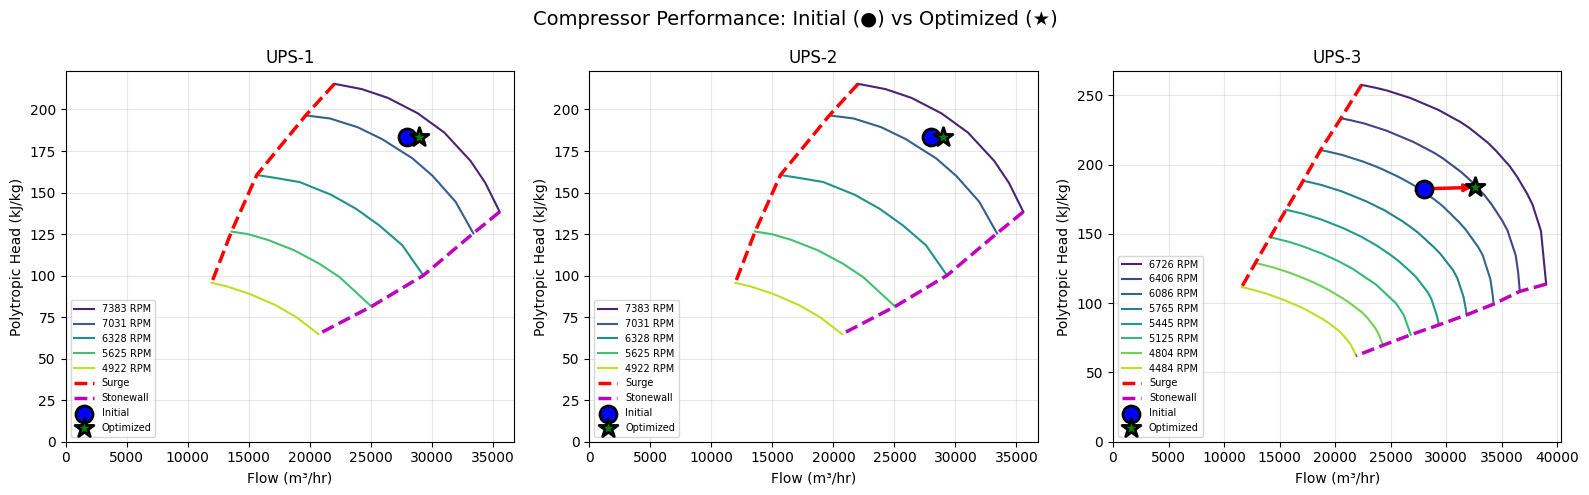


Operating Point & Power Comparison:
Compressor Init Flow    Opt Flow     Init Head   Opt Head    Power      Max Power  Util    
           (m³/hr)      (m³/hr)      (kJ/kg)     (kJ/kg)     (MW)       (MW)       (%)     
----------------------------------------------------------------------------------------------------
UPS-1      27989        28942        183.23      183.70      44.13      44.39      99.4    
UPS-2      27989        28942        183.23      183.70      44.13      44.39      99.4    
UPS-3      27989        32576        182.59      183.54      49.09      49.77      98.6    


In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Calculate initial operating points (equal 1/3 split at original flow)
compressor_splitter.setSplitFactors([1.0/3.0, 1.0/3.0, 1.0/3.0])
inlet_stream.setFlowRate(float(original_flow), "kg/hr")
process_system.run()

initial_points = {}
for name, comp in [("UPS-1", ups1_comp), ("UPS-2", ups2_comp), ("UPS-3", ups3_comp)]:
    initial_points[name] = {
        'flow': float(comp.getInletStream().getFlowRate("m3/hr")),
        'head': float(comp.getPolytropicHead("kJ/kg")),
        'speed': float(comp.getSpeed())
    }

# Step 2: Restore optimized state and capture optimized points
compressor_splitter.setSplitFactors([opt_split1, opt_split2, opt_split3])
inlet_stream.setFlowRate(float(best_flow), "kg/hr")
process_system.run()

optimized_points = {}
for name, comp in [("UPS-1", ups1_comp), ("UPS-2", ups2_comp), ("UPS-3", ups3_comp)]:
    optimized_points[name] = {
        'flow': float(comp.getInletStream().getFlowRate("m3/hr")),
        'head': float(comp.getPolytropicHead("kJ/kg")),
        'speed': float(comp.getSpeed())
    }

# Step 3: Plot compressor curves
def plot_compressor_curve(ax, compressor, comp_name, initial_pt, optimized_pt):
    """Plot compressor performance curves with operating points."""
    chart = compressor.getCompressorChart()
    if chart is None:
        ax.text(0.5, 0.5, "No chart data", transform=ax.transAxes, ha='center')
        return
    
    speeds = list(chart.getSpeeds())
    flow_data, head_data = chart.getFlows(), chart.getHeads()
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(speeds)))
    
    surge_pts, stonewall_pts = [], []
    for i, speed in enumerate(speeds):
        try:
            flows, heads = list(flow_data[i]), list(head_data[i])
            if flows and heads:
                ax.plot(flows, heads, '-', color=colors[i], lw=1.5, label=f'{speed:.0f} RPM')
                surge_pts.append((flows[0], heads[0]))
                stonewall_pts.append((flows[-1], heads[-1]))
        except:
            pass
    
    # Surge and stonewall boundaries
    if len(surge_pts) > 1:
        sf, sh = zip(*surge_pts)
        ax.plot(sf, sh, 'r--', lw=2.5, label='Surge')
    if len(stonewall_pts) > 1:
        swf, swh = zip(*stonewall_pts)
        ax.plot(swf, swh, 'm--', lw=2.5, label='Stonewall')
    
    # Operating points
    ax.scatter(initial_pt['flow'], initial_pt['head'], c='blue', s=150, marker='o', 
               edgecolors='black', lw=2, label='Initial', zorder=5)
    ax.scatter(optimized_pt['flow'], optimized_pt['head'], c='green', s=200, marker='*', 
               edgecolors='black', lw=2, label='Optimized', zorder=5)
    ax.annotate('', xy=(optimized_pt['flow'], optimized_pt['head']),
                xytext=(initial_pt['flow'], initial_pt['head']),
                arrowprops=dict(arrowstyle='->', color='red', lw=2.5))
    
    ax.set_xlabel('Flow (m³/hr)')
    ax.set_ylabel('Polytropic Head (kJ/kg)')
    ax.set_title(comp_name)
    ax.legend(loc='lower left', fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
compressors = [("UPS-1", ups1_comp), ("UPS-2", ups2_comp), ("UPS-3", ups3_comp)]

for ax, (name, comp) in zip(axes, compressors):
    plot_compressor_curve(ax, comp, name, initial_points[name], optimized_points[name])

plt.suptitle('Compressor Performance: Initial (●) vs Optimized (★)', fontsize=14)
plt.tight_layout()
plt.show()

# Step 4: Print comparison table
print("\n" + "=" * 100)
print("Operating Point & Power Comparison:")
print("=" * 100)
print(f"{'Compressor':<10} {'Init Flow':<12} {'Opt Flow':<12} {'Init Head':<11} {'Opt Head':<11} {'Power':<10} {'Max Power':<10} {'Util':<8}")
print(f"{'':10} {'(m³/hr)':<12} {'(m³/hr)':<12} {'(kJ/kg)':<11} {'(kJ/kg)':<11} {'(MW)':<10} {'(MW)':<10} {'(%)':<8}")
print("-" * 100)
for name, comp in compressors:
    init, opt = initial_points[name], optimized_points[name]
    power_mw = float(comp.getPower("kW")) / 1000.0
    driver = comp.getDriver()
    max_power_mw = driver.getMaxAvailablePowerAtSpeed(comp.getSpeed()) / 1000.0 if driver else 0
    util = (power_mw / max_power_mw * 100) if max_power_mw > 0 else 0
    print(f"{name:<10} {init['flow']:<12.0f} {opt['flow']:<12.0f} {init['head']:<11.2f} {opt['head']:<11.2f} {power_mw:<10.2f} {max_power_mw:<10.2f} {util:<8.1f}")